# Setup

In [1]:
# necessary libraries. 
import numpy as np
import pandas as pd
import seaborn as se
from sklearn import linear_model as LM
from sklearn import neighbors as NB
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import decomposition
import os
import shutil

In [2]:
if os.path.exists('/content/data/'):
  shutil.rmtree('/content/data')
# below are bash commands that are run in the computing environment, making a data directory
# and downloading the train and test data
!mkdir data
!wget https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/train.csv -P data
!wget https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/test.csv -P data


--2020-10-01 00:14:12--  https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18516136 (18M) [text/plain]
Saving to: ‘data/train.csv’

train.csv           100%[===================>]  17.66M  75.9MB/s    in 0.2s    

2020-10-01 00:14:12 (75.9 MB/s) - ‘data/train.csv’ saved [18516136/18516136]

--2020-10-01 00:14:12--  https://raw.githubusercontent.com/whitleyo/dcgsa_hackathon/master/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4646276 (4.4M) [text/pl

In [3]:
# Load in Data
top_dir = '/content'
data_dir = os.path.join(top_dir, 'data')
train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Examine Data

Our data consists of log fpkm values for 5 cell lines (A375, DLD1, GBM, HCT116, HELA, RPE1) and in subsequent columns (MAX and onwards) 1 for the presence of a protein protein interaction and 0 for the absense of an interaction.

In [4]:
train_data

,gene,IS_CORE_ESSENTIAL,A375,DLD1,GBM,HCT116,HELA,RPE1,MAX,MYCN,NMI,MYC,RPLP1,PDCD4,RPL5,RPS13,EIF4G1,TCF7L2,DAXX,CTNNB1,RUNX3,TLE1,LEF1,YWHAH,GREM1,NDE1,ZNF365,NDEL1,CDK1,UBE2I,TFAP2C,TFAP2A,TFAP2B,EP300,CITED2,ETS2,TWIST1,TWIST2,TP53,MDM2,...,TYMP,TSEN15,RAP1A,PSMB6,RAP1B,FOXA1,GFI1,NPY1R,PYY,CALCA,CALCRL,NPY2R,CXCR2,IL4R,IL4,EDNRA,EDN1,EDNRB,CCR3,CCL11,SIAH2,CASP10,CFLAR,BECN1,IRS1,BARD1,TDRD7,CDK17,LSM7,BNIP3L,BNIP2,BNIP3,SUV39H1,TGFB2,TPD52,TPD52L1,VANGL1,CD82,MAST2,CDHR2
0,SLC7A4,0,-5.887,-5.845,-6.644,-6.644,-6.644,-5.265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ERCC4,1,2.344,2.051,2.604,2.239,2.795,2.246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,EIF3G,1,7.561,7.053,6.966,7.232,6.758,6.816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,LARP1B,0,3.050,3.706,2.725,3.750,2.309,3.159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,DHX29,0,4.503,4.032,3.726,3.898,3.181,4.073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,WDR13,0,5.391,6.390,5.277,5.297,5.640,5.233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2707,RPL29,1,9.948,10.408,9.862,10.019,9.013,9.449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2708,TRMU,0,4.153,5.689,4.532,5.266,5.306,5.272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2709,DHX9,1,6.822,6.726,6.558,6.943,6.084,6.365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data

,gene,IS_CORE_ESSENTIAL,A375,DLD1,GBM,HCT116,HELA,RPE1,MAX,MYCN,NMI,MYC,RPLP1,PDCD4,RPL5,RPS13,EIF4G1,TCF7L2,DAXX,CTNNB1,RUNX3,TLE1,LEF1,YWHAH,GREM1,NDE1,ZNF365,NDEL1,CDK1,UBE2I,TFAP2C,TFAP2A,TFAP2B,EP300,CITED2,ETS2,TWIST1,TWIST2,TP53,MDM2,...,TYMP,TSEN15,RAP1A,PSMB6,RAP1B,FOXA1,GFI1,NPY1R,PYY,CALCA,CALCRL,NPY2R,CXCR2,IL4R,IL4,EDNRA,EDN1,EDNRB,CCR3,CCL11,SIAH2,CASP10,CFLAR,BECN1,IRS1,BARD1,TDRD7,CDK17,LSM7,BNIP3L,BNIP2,BNIP3,SUV39H1,TGFB2,TPD52,TPD52L1,VANGL1,CD82,MAST2,CDHR2
0,PDCD4,0,7.015,6.614,5.821,5.921,7.199,5.618,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,DAXX,0,5.275,5.670,5.319,5.751,4.520,5.507,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,RUNX3,0,3.581,-4.866,-4.808,3.612,0.051,-5.703,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TLE1,0,4.237,4.221,5.037,2.818,1.998,4.018,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,GREM1,0,-5.200,-5.520,-6.322,-6.179,-3.027,7.558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,TGFB2,0,-1.994,5.016,-0.448,-1.983,-0.146,6.664,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
674,TPD52,0,5.640,6.747,-5.381,6.984,6.346,1.369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
675,TPD52L1,0,4.521,5.792,4.425,4.604,5.937,4.751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
676,CD82,0,2.441,1.324,2.578,3.576,5.532,4.880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Setup train and test data. Train data is used to train model
Test data is used to assess how well model performs on unseen data

In [6]:
# columns 2 (0 is first column) and onwards give us our inputs
# column 1 gives us our label
X_train = train_data.iloc[:, 2:].to_numpy().astype('float32')
y_train = train_data.iloc[:, 1].to_numpy().astype('float32')

X_test = test_data.iloc[:, 2:].to_numpy().astype('float32')
y_test = test_data.iloc[:, 1].to_numpy().astype('float32')

For our inputs, we see that there are 3395 features, which we'll try to map to a binary output. We have 2711 training examples, 678 test examples.

In [7]:
X_train.shape

(2711, 3395)

In [8]:
y_train.shape

(2711,)

In [9]:
X_test.shape

(678, 3395)

In [10]:
y_test.shape

(678,)

Let's get the lay of the land: we run PCA to see data in reduced dimension space

In [11]:
pca_object = decomposition.PCA(n_components = 5)
pca_object.fit(X_train)
X_train_PCA = pca_object.transform(X_train)

In [12]:
X_train_PCA.shape

(2711, 5)

[Text(0, 0.5, 'Variance Explained'), Text(0.5, 0, 'PC')]

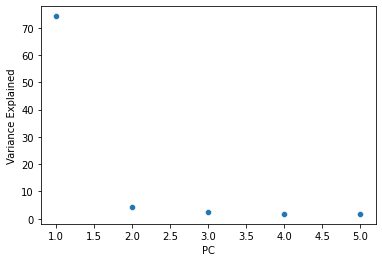

In [13]:
g = se.scatterplot(x = range(1, 6), y = pca_object.explained_variance_)
g.set(xlabel = 'PC', ylabel = 'Variance Explained')

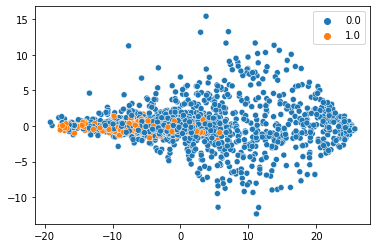

In [14]:
g = se.scatterplot(x = X_train_PCA[:, 0], y = X_train_PCA[:, 1], hue = y_train)

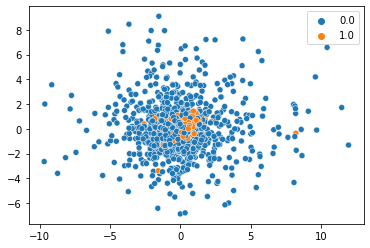

In [15]:
g = se.scatterplot(x = X_train_PCA[:, 2], y = X_train_PCA[:, 3], hue = y_train)

# Train Model

## Example I: Logistic Regression

Here, we use a logistic regression model with elasticnet penalty. We do a grid search of parameters looking for optimal cross validation performance. 

For more on these topics:

* [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

* [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

Note that we only use a subset of the data for speed.


In [16]:
# Let's try logistic regression

logistic = LM.LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 100)
logistic_param_grid = {'C': [1.0, 0.1],
                      'l1_ratio': [1.0, 0.5]}
logistic_CV_search = GridSearchCV(logistic, logistic_param_grid)
logistic_CV_search.fit(X_train[0:100, :], y_train[0:100])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 0.1], 'l1_ratio': [1.0, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
logistic_CV_search.best_params_

{'C': 0.1, 'l1_ratio': 1.0}

In [18]:
# Train Accuracy
logistic_CV_search.score(X_train, y_train)

0.7867945407598672

In [19]:
# Test Accuracy
logistic_CV_search.score(X_test, y_test)

0.7831858407079646

Note that for assessing performance, you can also use 
```
y_pred = result.predict(X_test)
score = sklearn.metrics.accuracy_score(y_pred, y_test)
``` 
where result is just the trained model, y_pred is the predictions given X_test,
and score is your accuracy metric. 


## Example II: K Nearest Neighbors

We try predicting the value of y by taking the k-nearest neighbors in our training data and taking the most common class among these neighbors. Nearest just means minimum euclidean distance if we're using default settings. During the cross validation step, the model is trained with a subset of the data and predictions are made based on the k-neighbors in that subset. During testing, the model, retrained on the entire training set.

Here we're only using a subset of the training set for the sake of speed.

In [20]:
# Try KNN
KNN = NB.KNeighborsClassifier()
KNN_param_grid = {'n_neighbors': range(10,16)}
KNN_CV_search = GridSearchCV(KNN, KNN_param_grid)
KNN_CV_search.fit(X_train[0:1000, :], y_train[0:1000])

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(10, 16)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [21]:
KNN_CV_search.best_params_

{'n_neighbors': 10}

In [22]:
# Train Accuracy
KNN_CV_search.score(X_train, y_train)

0.7967539653264478

In [23]:
# Test Accuracy
KNN_CV_search.score(X_test, y_test)

0.7920353982300885